### Parameters, imports etc.

In [2]:
from google.colab import drive
drive.mount('Drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at Drive


In [1]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.9 GB  | Proc size: 119.9 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


In [3]:
%cd Drive/My\ Drive/Project
%pip install keras_tqdm



/content/Drive/My Drive/Project


In [4]:
import io
import numpy as np
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras import optimizers
from keras_tqdm import TQDMNotebookCallback
from skimage import color
from clr_callback import *
from hdfstore import *
from Utils import *
from tqdm import tqdm
import keras as k
import matplotlib.pyplot as plt
import h5py
import cv2 as cv
from keras.models import load_model

'''
Conf specifies model architechture where 1 row of conf specifies one layer: = 
[No. filters, stride, dialation, BatchNorm_bool, upsampling_bool]
'''

conf =  [[64,  1, (1,1), False, False],
         [64,  2, (1,1), True,  False],
         [128, 1, (1,1), False, False],
         [128, 2, (1,1), True,  False],
         [256, 1, (1,1), False, False],
         [256, 1, (1,1), False, False],
         [256, 2, (1,1), True,  False],
#         [512, 1, (1,1), False, False],
#         [512, 1, (1,1), False, False],
#         [512, 1, (1,1), True,  False],
         [512, 1, (2,2), False, False],
         [512, 1, (2,2), False, False],
         [512, 1, (2,2), True,  False],
#          [512, 1, (2,2), False, False],
#          [512, 1, (2,2), False, False],
#          [512, 1, (2,2), True,  False],
         [256, 1, (1,1), False, False],
         [256, 1, (1,1), False, False],
         [256, 1, (1,1), True,  False], 
         [128, 1, (1,1), False, True ],
         [128, 1, (1,1), False, False],
         [128, 1, (1,1), False, False]]



Using TensorFlow backend.


### Build model

In [6]:
class LossHistory(k.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

        
#history = LossHistory()
#cvs_logger = CSVLogger('losses_CB.csv', separator=',', append=True)

training_generator = DataGenerator('train', 100000)
validation_generator = DataGenerator('val', 1000)
loss = training_generator.multinomal_cross_entropy

history = LossHistory()
#model = net_builder(conf)
model = load_model('best_model_classRebal.h5', custom_objects={'multinomal_cross_entropy': loss})
opti = optimizers.Adam(lr=1e-7, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss = loss, optimizer = opti, metrics = ['accuracy'])
mc = ModelCheckpoint('best_model_classRebal.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)
clr = CyclicLR(base_lr=1e-7, max_lr=1e-6, step_size=250)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


### Fit model

In [0]:
model_trained = model.fit_generator(generator=training_generator, epochs = 500, validation_data=validation_generator, 
                    callbacks=[mc, clr, TQDMNotebookCallback()], verbose = 0)

### Load best model from callbacks

In [0]:
saved_model = load_model('best_model.h5')

### Plot loss curves

In [0]:
plt.plot(history.losses)

NameError: ignored

In [0]:
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(18, 6))
ax1.set_title('Training loss')
ax2.set_title('Validation loss')
ax1.plot(history)
ax2.plot(history)
plt.savefig('first_train_using_cyclic.pdf')
plt.show()

### Training image comparrisons

In [0]:
imgs = load_data('Data/train_data_batch_1')

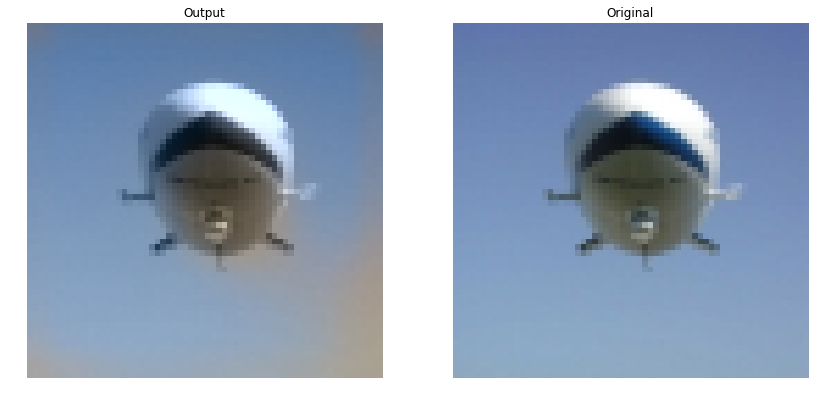

In [0]:
c = 7

sample = np.reshape(gen_input(imgs[c]), (1,64,64,1))

orig = np.resize(sample, (64,64,1))
img = model.predict(sample)
img = decode_prediction(img)
img = cv.resize(img, (64, 64), cv.INTER_CUBIC)
img_lab_out = np.concatenate((orig+50,img),axis=2)
img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8')

#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 14))
ax1.set_title('Output')
ax1.imshow(img_rgb_out)
ax2.set_title('Original')
ax1.axis('off')
ax2.axis('off')
ax2.imshow(imgs[c])
plt.show()

### Validation image comparrisons

In [0]:
val = load_data('Data/val_data')

In [0]:
c = 63

sample = np.reshape(val_inps[c], (1,64,64,1))
orig = np.resize(sample, (64,64,1))
img = saved_model.predict(sample)
img = decode_prediction(img)
img = cv.resize(img, (64, 64), cv.INTER_CUBIC)
img_lab_out = np.concatenate((orig+50,img),axis=2)
img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8')

#Creates two subplots and unpacks the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2,figsize=(14, 14))
ax1.set_title('Output')
ax1.imshow(img_rgb_out)
ax2.set_title('Original')
ax1.axis('off')
ax2.axis('off')
ax2.imshow(val[c])
plt.show()